In [1]:
import numpy as np
import os, glob, sys
import time, datetime, calendar
import pytz
import xarray as xr
import matplotlib.pyplot as plt

In [ ]:
startdate = '20181015.0000'
enddate = '20190303.0000'

# Maximum time difference allowed to match the datasets
time_window = 40  # [second]

# Input/output file locations
# stats_path = os.path.expandvars('$ICLASS') + f'/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1/stats/'
stats_path = f'/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_mpgridded_celltracking.c1/stats/'
sonde_path = f'/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/sounding_stats/'
output_path = stats_path

In [ ]:
stats_path

In [ ]:
# Input file basenames
stats_filebase = 'stats_tracknumbersv1.0_'

# Output statistics filename
output_filename = f'{output_path}interpsonde_celltrack_{startdate}_{enddate}.nc'

# Track statistics file dimension names
trackdimname = 'tracks'
timedimname = 'times'
relative_time_dimname = 'reltime'

# Track statistics file
trackstats_file = f'{stats_path}{stats_filebase}{startdate}_{enddate}.nc'
muparcel_file = f'{sonde_path}Interpsonde_parameters_CACTI_AMF.nc'
# uvq_file = f'{sonde_path}CACTI_M1_interpsonde_wind_humidity_indices.nc'

In [ ]:
# Read track statistics file
print(trackstats_file)
dsstats = xr.open_dataset(trackstats_file, decode_times=False)
ntracks = dsstats.dims[trackdimname]
# ntimes = dsstats.dims[timedimname]
stats_basetime = dsstats['basetime']
basetime_units = dsstats['basetime'].units
# cell_area = dsstats['cell_area'].values
# pixel_radius = dsstats.attrs['pixel_radius_km']
# Get cell initiation time
stats_basetime0 = stats_basetime.sel(times=0).data
dsstats.close()

print(f'Total Number of Tracks: {ntracks}')

In [ ]:
# Read sonde MU parcel file
dsmup = xr.open_dataset(muparcel_file, decode_times=False)
sonde_basetime = dsmup.time.values
dsmup

In [ ]:
sonde_var_names = list(dsmup.data_vars.keys())

In [ ]:
sonde_var_names[1]

In [ ]:
print(sonde_var_names[0])
dsmup[sonde_var_names[0]].values

In [ ]:
print(sonde_var_names[1])
dsmup[sonde_var_names[1]].values

In [ ]:
# "".join(chartostring(cloudidfiles))

In [ ]:
sonde_var_names.remove('yyyymmdd')
sonde_var_names.remove('hhmmss')

In [ ]:
# Number of relative sonde time to track initiation (-3, -2, -1, 0 hour)
nreltime = 4
# sonde_matchtime = np.full((ntracks,nreltime), dtype=float, fill_value=np.nan)

out_vars = {}
nvars = len(sonde_var_names)
for ivar in sonde_var_names:
#     print(ivar)
    out_vars[ivar] = np.full((ntracks, nreltime), dtype=float, fill_value=np.nan)

# out_vars['time'] = np.full((ntracks, nreltime), dtype=float, fill_value=np.nan)

In [ ]:
# # Remove variables in the dictionary
# out_vars.pop('yyyymmdd', 'No key found')
# out_vars.pop('hhmmss', 'No key found')

In [ ]:
tt = 0

In [19]:
matchindex = np.zeros(ntracks, dtype= np.int)
matchindex_1h = np.zeros(ntracks, dtype= np.int)
matchindex_2h = np.zeros(ntracks, dtype= np.int)
matchindex_3h = np.zeros(ntracks, dtype= np.int)
skip_tracks = []

In [21]:
%%time
# Loop over each cell track to find match sonde time
one_hour = 3600 # one hour
counts = 0

for tt in range(0, ntracks):
    # Tracks at initiation time
    matchindex[tt] = np.argmin(np.abs(sonde_basetime - stats_basetime0[tt]))
    # Initiation time -1, -2, -3 hour 
    matchindex_1h[tt] = np.argmin(np.abs(sonde_basetime[0:matchindex[tt]] - (stats_basetime0[tt] - one_hour*1))) 
    matchindex_2h[tt] = np.argmin(np.abs(sonde_basetime[0:matchindex[tt]] - (stats_basetime0[tt] - one_hour*2)))
    matchindex_3h[tt] = np.argmin(np.abs(sonde_basetime[0:matchindex[tt]] - (stats_basetime0[tt] - one_hour*3)))
    

    if (sonde_basetime[matchindex[tt]] - stats_basetime0[tt] > time_window) | \
        (sonde_basetime[matchindex_1h[tt]] - stats_basetime0[tt]+ one_hour > time_window) |\
        (sonde_basetime[matchindex_2h[tt]] - stats_basetime0[tt]+2*one_hour > time_window) |\
        (sonde_basetime[matchindex_3h[tt]] - stats_basetime0[tt]+3*one_hour > time_window):
        print(f'No match sonde time found: {stats_basetime0[tt]}')
        skip_tracks.append(tt)
        continue

        # Note we'd still want to in the next step blank out any tracks in skip_tracks

CPU times: user 1.6 s, sys: 0 ns, total: 1.6 s
Wall time: 1.6 s


In [22]:
%%time
for ivar in sonde_var_names:
    out_vars[ivar][:,0] = dsmup[ivar].values[matchindex, ]
    out_vars[ivar][:,1] = dsmup[ivar].values[matchindex_1h]
    out_vars[ivar][:,2] = dsmup[ivar].values[matchindex_2h]
    out_vars[ivar][:,3] = dsmup[ivar].values[matchindex_3h]

CPU times: user 394 ms, sys: 82.2 ms, total: 477 ms
Wall time: 473 ms


(array([1768.,  732.,  425.,  323.,  351.,  209.,   85.,   89.,   71.,
          37.,   83.,  119.,   56.,   29.,   23.,   23.,   14.,   21.,
          10.,    7.,   11.,   17.,   15.,    9.,    5.,    0.,    0.,
           0.,    0.,    2.,    0.,    0.,    0.,    2.]),
 array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000,
        2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200,
        4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200, 6400,
        6600, 6800]),
 <a list of 34 Patch objects>)

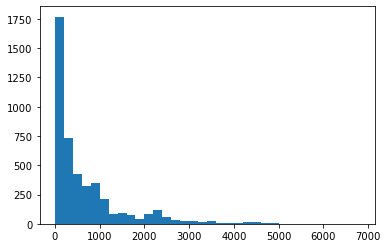

In [23]:
plt.hist(out_vars['CAPE_sfc'][:,0], bins=np.arange(0,7000,200))

In [49]:
out_vars['CAPE_sfc'][:,0]

array([nan, nan, nan, ..., nan, nan, nan])

In [116]:
np.where(np.abs(sonde_basetime - stats_basetime0[0]) < 35)[0]

array([274])

In [105]:
time_window

10

In [90]:
# sonde_vars['']

<xarray.Dataset>
Dimensions:  (time: 18624)
Coordinates:
  * time     (time) float64 1.539e+09 1.539e+09 ... 1.557e+09 1.557e+09
Data variables:
    *empty*